In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt').read().splitlines()
chars = sorted(set(''.join(words)))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}

In [3]:
def build_dataset(words):
    block_size = 3

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xtest,Ytest = build_dataset(words[n2:])

print(len(Xtr),len(Ytr),len(Xdev),len(Ydev),len(Xtest),len(Ytest))

182323 182323 22919 22919 22904 22904


In [4]:
C = torch.rand((27,3))
print(C[5])
F.one_hot(torch.tensor(5),num_classes=27).float() @ C


tensor([0.6316, 0.8141, 0.0377])


tensor([0.6316, 0.8141, 0.0377])

In [5]:
emb = C[Xtr]
emb.shape
#C is just initialized to random at the begining
C[Xtr]
#Each character is represented as an embedding

tensor([[[0.8160, 0.5552, 0.0585],
         [0.8160, 0.5552, 0.0585],
         [0.8160, 0.5552, 0.0585]],

        [[0.8160, 0.5552, 0.0585],
         [0.8160, 0.5552, 0.0585],
         [0.8929, 0.6380, 0.0791]],

        [[0.8160, 0.5552, 0.0585],
         [0.8929, 0.6380, 0.0791],
         [0.5960, 0.2511, 0.9285]],

        ...,

        [[0.5960, 0.2511, 0.9285],
         [0.5305, 0.9730, 0.5012],
         [0.6380, 0.8477, 0.2383]],

        [[0.5305, 0.9730, 0.5012],
         [0.6380, 0.8477, 0.2383],
         [0.6316, 0.8141, 0.0377]],

        [[0.6380, 0.8477, 0.2383],
         [0.6316, 0.8141, 0.0377],
         [0.6316, 0.8141, 0.0377]]])

In [6]:
C = torch.randn(27,3)
W1 = torch.randn(9,100) #3 context size, 3 embedding dimensions (3*3 = 9) times 100 neurons
b1 = torch.randn(100)
W2 = torch.randn(100,27)
b2 = torch.randn(27)
parameters = [C,W1,b1,W2,b2]
sum(p.nelement() for p in parameters)

3808

In [7]:
for p in parameters:
    p.requires_grad=True

In [8]:
torch.randint(Xtr.shape[0],(32,))

tensor([ 16906, 120508,  59689, 101185, 172488, 174521,  50257, 159884, 133851,
         14830,  72643,  71955, 148251, 129956, 131038,  24832, 149534, 159599,
         23494,  21136,  47144, 123422, 129525,  39980, 164540, 112121,  19593,
          7397,  67474,  10145,  78640, 162920])

In [9]:
for i in range(300000):
    #pick a few in random
    ix = torch.randint(Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,9)@W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data  += -0.01 * p.grad
    print(loss.item())

18.725542068481445
19.444353103637695
18.020830154418945
17.525081634521484
16.134845733642578
18.61288070678711
20.670969009399414
16.795042037963867
15.791050910949707
16.830093383789062
16.508895874023438
17.478424072265625
17.38779640197754
17.319631576538086
19.365406036376953
17.10050392150879
20.936355590820312
18.563720703125
15.677168846130371
17.562223434448242
18.1159725189209
15.77361011505127
17.546550750732422
14.952701568603516
16.113849639892578
17.359243392944336
16.622730255126953
14.859366416931152
17.571046829223633
15.917082786560059
16.55640411376953
17.886070251464844
13.078746795654297
13.5250244140625
17.317829132080078
16.532033920288086
16.32185935974121
14.409634590148926
13.792628288269043
15.276947975158691
14.26518440246582
15.512678146362305
15.57637882232666
13.543715476989746
13.69570255279541
14.916930198669434
13.026470184326172
17.644033432006836
14.275997161865234
13.857198715209961
15.219780921936035
15.261496543884277
15.94677448272705
11.6790218

In [16]:
loss

tensor(2.3452, grad_fn=<NllLossBackward0>)

In [11]:
#just do a forward pass to find out how close is it to dev set which training did not see
emb = C[Xdev]
h = torch.tanh(emb.view(-1,9)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.3452, grad_fn=<NllLossBackward0>)

In [12]:
C_vis = C.detach()
C_vis

tensor([[ 0.0918,  0.1238, -0.0990],
        [ 0.4170, -0.0857, -0.5324],
        [ 0.6726, -0.0918, -0.1425],
        [ 0.6744, -0.1249, -0.0848],
        [ 0.6506, -0.2056, -0.1079],
        [ 0.4778, -0.2652, -0.7191],
        [ 0.7042, -0.1731, -0.0586],
        [ 0.6585, -0.0782, -0.1057],
        [ 0.4579, -0.2738, -0.1849],
        [ 0.4209, -0.4977, -0.7281],
        [ 0.4655, -0.4438, -0.1343],
        [ 0.6467, -0.2127, -0.0940],
        [ 0.7674, -0.5269, -0.2001],
        [ 0.6186, -0.2824, -0.0442],
        [ 0.5199, -2.9687,  1.1887],
        [ 0.3659, -0.2137, -0.6805],
        [ 0.6810, -0.0458, -0.0445],
        [-0.2042,  2.0881,  1.2541],
        [ 0.6675, -0.3935, -0.1936],
        [ 0.6493, -0.1025, -0.1517],
        [ 0.7182, -0.1095, -0.0912],
        [ 0.4777, -3.3082,  0.6923],
        [ 0.8364, -0.3035, -0.0478],
        [ 0.6549, -0.2105, -0.1489],
        [ 0.6216, -0.1962, -0.2024],
        [ 0.2986, -0.6458, -0.5215],
        [ 0.6558, -0.3078, -0.1114]])

In [13]:
chars[0] = 'a'
labels = ['.']+chars
labels

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

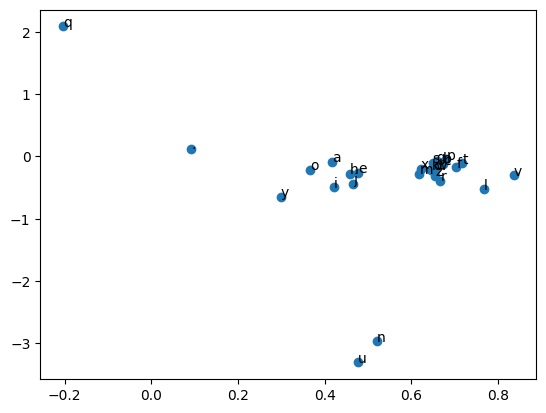

In [14]:
plt.scatter(C_vis[:,0],C_vis[:,1])
for i, label in enumerate(labels):
    plt.text(C_vis[:,0][i],C_vis[:,1][i], label)


<module 'matplotlib.pyplot' from '/Users/gavi/miniconda3/envs/makemore/lib/python3.11/site-packages/matplotlib/pyplot.py'>

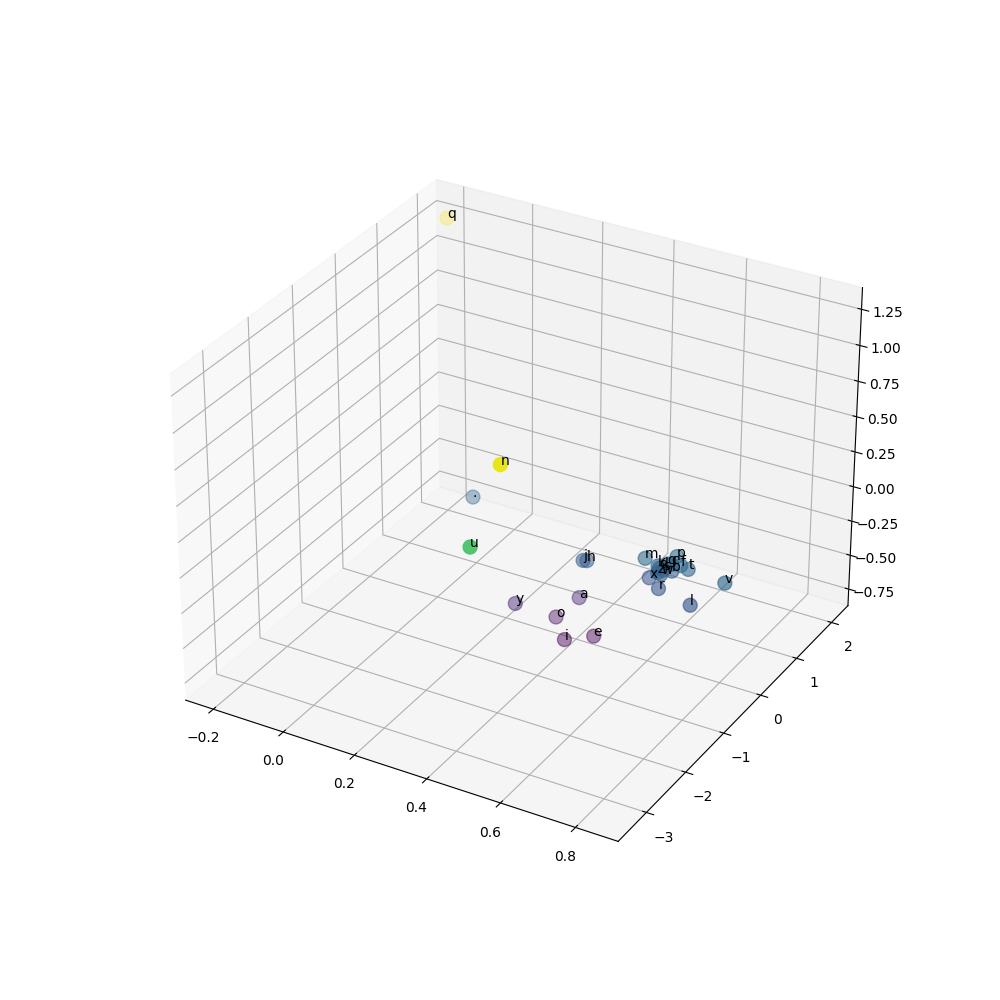

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
%matplotlib widget

# Create a 3D scatter plot
scatter = ax.scatter(C_vis[:, 0], C_vis[:, 1], C_vis[:, 2], c=C_vis[:, 2], cmap='viridis', s=100)

for i, label in enumerate(labels):
    ax.text(C_vis[:,0][i],C_vis[:,1][i],C_vis[:,2][i], label)
# Show the plot
plt